<H1>Risk Dashboard</H1>
This example shows some tools that can be used to monitor risk limits of an actual traded portfolio. The example is based on a CTA (Commodity Hedge fund ) portfolio.

In [1]:
"""
    Import Libraries
"""
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm 
import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns
from IPython.display import display, HTML
import XIgniteLib as xf
mktData = xf.MarketData()
%matplotlib inline

<H2>Reading Data</H2><P>
We read a sample CTA portfolio that consist of a number of future contracts. We do not specify month and year maturity of each contract in order to keep the example consistent through time. Instead we use on the run futures for each contract. 

Since XIGnite is a paid service we only perform the data request once. The XIgnite module included here shows sample code but obviouslu does not show credentials for loging into XIGnite data service. Please visit <a href="http://www.xignite.com">XIgnite</a> for more information


In [2]:
port = pd.DataFrame.from_csv("data/ctaport2.csv")
contracts = port.index

In [3]:
for ticker in contracts:
    s = mktData.get_next_future(ticker)
    if (s['Outcome'] == 'Success'):
        port.loc[ticker,'Price'] = 0
        port.loc[ticker,'MarketValue'] = 0
        quote = mktData.get_future_quote(ticker,s['Month'],s['Year'])
        if quote['Outcome'] == 'Success':
            pr = quote['Last']  
            port.loc[ticker,'Price'] = pr
            mktvalue = port.loc[ticker,'Point Value'] * port.loc[ticker,'Shares'] * pr
            port.loc[ticker,'MarketValue'] = mktvalue
            port.loc[ticker,'GrossValue'] = np.abs(mktvalue)
            port.loc[ticker,'PctChange'] = quote['PercentChange'] * 0.01
            port.loc[ticker,'PrevClose'] = quote['PreviousClose']
            shares = port.loc[ticker,'Shares']
            if (shares > 0):
                port.loc[ticker,'WorstMove'] = port.loc[ticker,'Min']
            else:
                port.loc[ticker,'WorstMove'] = port.loc[ticker,'Max']
        else:
            port.loc[ticker,'Price'] = 0

<H2>Determining position limits</H2>
<P>
For this example we assume that the fund has 3% fo NAV limit for a loss in each contract. We therefore determine the current limit and number of availanble contracts that the fund can still allocate to. 
</P>
<P>
One way to do that is to determine the Expected Max Loss (E(L)) based on historical worst movement in the contract (W). W is dependent on the sign of the position. If the fund is long a contract then the W is defined by the highest daily loss. If the fund is short the contract then W is defined by the highest daily gain. 
</P>
<img src="https://dl.dropbox.com/s/242k4mszbtps7md/formula.png?dl=0"/>
<br>
For each contract in the portfolio we, therefore, calculate Maximum number of allowed contracts and Expected Loss given current number of contracts held. In the example portfolio we clear see several violations

#Calculate Maximum 
A = 100000000
L = 0.03
port['MaxContracts'] = A*L/(port['Point Value']*port['Price']* port['WorstMove'] *-1)
port['E(L)'] = port['Shares']*port['Price']*port['Point Value']*port['WorstMove']*-1/A                    



In [7]:
#Calculate Maximum 
A = 100000000 #AUM
L = 0.03 #Max Loss
port['MaxContracts'] = A*L/(port['Point Value']*port['Price']* port['WorstMove'] *-1)
port['E(L)'] = port['Shares']*port['Price']*port['Point Value']*port['WorstMove']*-1/A                    


<h3>Display Portfolio Limist for each contract</h3>

In [8]:
port[['Name','Type','Shares','MaxContracts','Price','MarketValue','E(L)']]

,Name,Type,Shares,MaxContracts,Price,MarketValue,E(L)
Contract,,,,,,,
CL,Crude Oil,ENGY,300,360.912732,45.790,13737000.0,0.024937
NG,Natural Gas,ENGY,-7000,-7157.171486,2.994,-2095800.0,0.029341
SP,S&P 500 Index,STOCK,-38,-47.791792,2168.300,-20598850.0,0.023853
GD,S&P GSCI,STOCK,110,491.455735,358.550,9860125.0,0.006715
GC,Gold,Metals,-212,-206.871048,1340.400,-28416480.0,0.030744
SI,Silver,Metals,120,174.143114,20.020,12012000.0,0.020673
KC,Coffee,AGG,550,267.423274,155.250,32020312.5,0.061700
SB,Sugar,AGG,950,691.306520,22.170,23588880.0,0.041226


<h3>Visualize Risk Limits</H3>
<article>The following charts show the current positions in each contract as well as number of availble contracts that can be allocated (if any)</article>

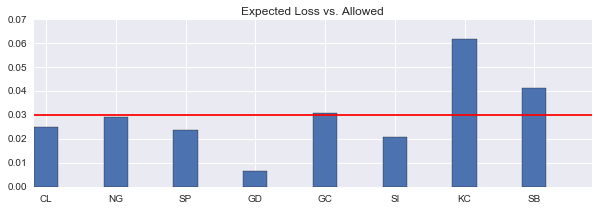

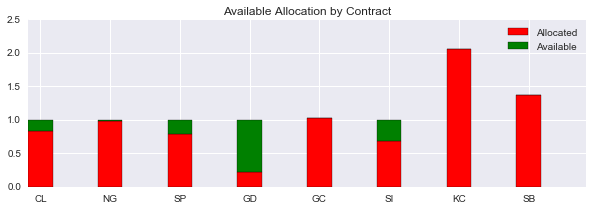

In [12]:
plt.figure(figsize=(10,3))
width = 0.35 
N = len(port)
plt.bar(np.arange(N),port['E(L)'],width)
plt.plot(np.arange(N+1),np.ones(N+1)*0.03,'r')
plt.title('Expected Loss vs. Allowed')
plt.xticks(np.arange(N)+width/2,port.index)
plt.figure(figsize=(10,3))
usedalloc = port['Shares']/port['MaxContracts'].values
unusedalloc = [1-u if u < 1 else 0 for u in usedalloc]  
p1 = plt.bar(np.arange(N),usedalloc,width,color='r')
p2 = plt.bar(np.arange(N),unusedalloc,width,bottom=usedalloc,color='g')
plt.title('Available Allocation by Contract')
plt.xticks(np.arange(N)+width/2,port.index)
plt.legend((p1[0],p2[0]),('Allocated','Available'))

<i>The fund can no longer allocate capital to Natural Gas (NG),  Gold (GC), Coffee (KC) and Sugar (SB) contracts</i>

<H2>Value at Risk / Size of Daily Moves</H2>
We calculated VaR based on the daily moves of the last 100 days. The VaR for each contract reported here is static. It can, of course, be updated daily but since market data is not free we are using static data for demonstration purposes. 
<br>
The following chart shows daily move in each contract and plots the movement. The red line shows VaR. The yellow line shows the absolute value of VaR and is shown here as possible flag to indicate large abnormal moves.

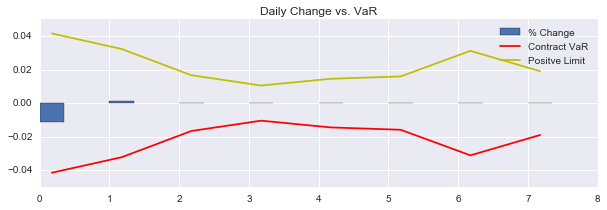

In [14]:
plt.figure(figsize=(10,3))
p1 = plt.bar(np.arange(N),port['PctChange'],width)
p2 = plt.plot(np.arange(N)+width*0.5,port['VaR'],color='r')
p3 = plt.plot(np.arange(N)+width*0.5,np.abs(port['VaR']),color='y')


plt.title('Daily Change vs. VaR')

plt.legend((p1[0],p2[0],p3[0]),('% Change','Contract VaR','Positve Limit'))